<a href="https://colab.research.google.com/github/chaiminwoo0223/Deep-Learning/blob/main/29%20-%20DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN

- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks(https://arxiv.org/pdf/1511.06434.pdf)

![alt text](http://2.bp.blogspot.com/-oMyhHfxOqiE/WKF4KlVYWJI/AAAAAAAABRs/6BDIypy1hn0U8MGRFxfVaXOcQDO7vX1cQCK4B/s1600/dcgan-architecture.PNG)

# Import

In [1]:
import os
import torch
import torch.nn as nn
import torch.utils as utils
import torch.optim as optim
import torch.nn.init as init
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from collections import OrderedDict

# Hyperparameter

In [2]:
epoch = 100
batch_size = 512
lr = 0.0002

# Data

In [3]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ]),target_transform=None, download=True)
train_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 96080383.17it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 101284024.94it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24791784.44it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21922357.62it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# Model
## 1.Generator

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(100, 7*7*256),
            nn.BatchNorm1d(7*7*256),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(OrderedDict([
            ('conv1', nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)), # batch x 128 x 14 x 14
            ('bn1', nn.BatchNorm2d(128)),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)),           # batch x 64 x 14 x 14
            ('bn2', nn.BatchNorm2d(64)),
            ('relu2', nn.ReLU())
        ]))
        self.layer3 = nn.Sequential(OrderedDict([
            ('conv3', nn.ConvTranspose2d(64,16, kernel_size=4, stride=2, padding=1)),    # batch x 16 x 28 x 28
            ('bn3', nn.BatchNorm2d(16)),
            ('relu3', nn.ReLU()),
            ('conv4', nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1)),             # batch x 1 x 28 x 28
            ('relu4', nn.Tanh())
        ]))
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)

    def forward(self, z):
        out = self.layer1(z)
        out = out.view(batch_size, 256, 7, 7)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

## 2.Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)),           # batch x 8 x 28 x 28
            ('relu1', nn.LeakyReLU()),
            ('conv2', nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)),          # batch x 16 x 14 x 14
            ('bn2', nn.BatchNorm2d(16)),
            ('relu2', nn.LeakyReLU())
        ]))
        self.layer2 = nn.Sequential(OrderedDict([
            ('conv3', nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)),         # batch x 32 x 14 x 14
            ('bn3', nn.BatchNorm2d(32)),
            ('relu3', nn.LeakyReLU()),
            ('conv4', nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)),         # batch x 64 x 7 x 7
            ('bn4', nn.BatchNorm2d(64)),
            ('relu4', nn.LeakyReLU())
        ]))
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7, 1),
            nn.Sigmoid()
        )
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out

## 3.Model On GPU

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [7]:
generator = nn.DataParallel(Generator()).to(device)
discriminator = nn.DataParallel(Discriminator()).to(device)
gen_params = generator.state_dict().keys()
dis_params = discriminator.state_dict().keys()

for i in gen_params:
    print("gen_params:", i)
print("\n")
for j in dis_params:
    print("dis_params:", j)

gen_params: module.layer1.0.weight
gen_params: module.layer1.0.bias
gen_params: module.layer1.1.weight
gen_params: module.layer1.1.bias
gen_params: module.layer1.1.running_mean
gen_params: module.layer1.1.running_var
gen_params: module.layer1.1.num_batches_tracked
gen_params: module.layer2.conv1.weight
gen_params: module.layer2.conv1.bias
gen_params: module.layer2.bn1.weight
gen_params: module.layer2.bn1.bias
gen_params: module.layer2.bn1.running_mean
gen_params: module.layer2.bn1.running_var
gen_params: module.layer2.bn1.num_batches_tracked
gen_params: module.layer2.conv2.weight
gen_params: module.layer2.conv2.bias
gen_params: module.layer2.bn2.weight
gen_params: module.layer2.bn2.bias
gen_params: module.layer2.bn2.running_mean
gen_params: module.layer2.bn2.running_var
gen_params: module.layer2.bn2.num_batches_tracked
gen_params: module.layer3.conv3.weight
gen_params: module.layer3.conv3.bias
gen_params: module.layer3.bn3.weight
gen_params: module.layer3.bn3.bias
gen_params: module.la

## 4.Loss_Func & Optimizer

In [8]:
loss_func = nn.MSELoss()
gen_optim = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
dis_optim = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
ones_label = torch.ones(batch_size, 1).to(device)
zeros_label = torch.zeros(batch_size, 1).to(device)

# Restore

In [9]:
try:
  os.mkdir("./model")
except:
  pass

try:
  os.mkdir("./result")
except:
  pass

# Train

In [10]:
for i in range(epoch):
    for j, (image, label) in enumerate(train_loader):
        image = image.to(device)
        # Generator
        gen_optim.zero_grad()
        z = init.normal_(torch.Tensor(batch_size, 100), mean=0, std=0.1).to(device)
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake) # Fake Data
        gen_loss = torch.sum(loss_func(dis_fake, ones_label))
        gen_loss.backward()
        gen_optim.step()
        # Discriminator
        dis_optim.zero_grad()
        z = init.normal_(torch.Tensor(batch_size, 100), mean=0, std=0.1).to(device)
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake) # Fake Data
        dis_real = discriminator.forward(image)    # Real Data
        dis_loss = torch.sum(loss_func(dis_fake, zeros_label)) + torch.sum(loss_func(dis_real, ones_label))
        dis_loss.backward()
        dis_optim.step()
        # Model Save
        if j % 1000 == 0:
            print("{}th iteration gen_loss: {} dis_loss: {}".format(i,gen_loss.data,dis_loss.data))
            torch.save([generator,discriminator],'./model/dcgan.pkl')
            v_utils.save_image(gen_fake.cpu().data[0:25],"./result/gen_{}_{}.png".format(i,j), nrow=5)

0th iteration gen_loss: 0.2540319263935089 dis_loss: 0.8007088899612427
1th iteration gen_loss: 0.7306019067764282 dis_loss: 0.13908977806568146
2th iteration gen_loss: 0.7117331624031067 dis_loss: 0.09159569442272186
3th iteration gen_loss: 0.7938345670700073 dis_loss: 0.030684569850564003
4th iteration gen_loss: 0.988472044467926 dis_loss: 0.0056871892884373665
5th iteration gen_loss: 0.9198180437088013 dis_loss: 0.015604632906615734
6th iteration gen_loss: 0.9969875812530518 dis_loss: 0.004351350944489241
7th iteration gen_loss: 0.9135664701461792 dis_loss: 0.0014674910344183445
8th iteration gen_loss: 0.9410649538040161 dis_loss: 0.0027311784215271473
9th iteration gen_loss: 0.9585264921188354 dis_loss: 0.001961220521479845
10th iteration gen_loss: 0.9999964833259583 dis_loss: 0.0004998996737413108
11th iteration gen_loss: 0.9999940395355225 dis_loss: 2.520211819501128e-05
12th iteration gen_loss: 0.9999923706054688 dis_loss: 3.4331507777096704e-05
13th iteration gen_loss: 0.999988

0
0th ['./result/gen_0_0.png']


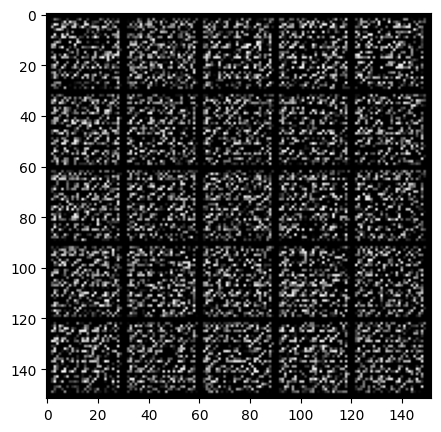

5
5th ['./result/gen_5_0.png']


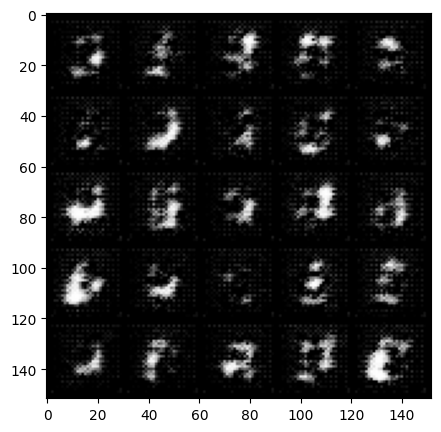

10
10th ['./result/gen_10_0.png']


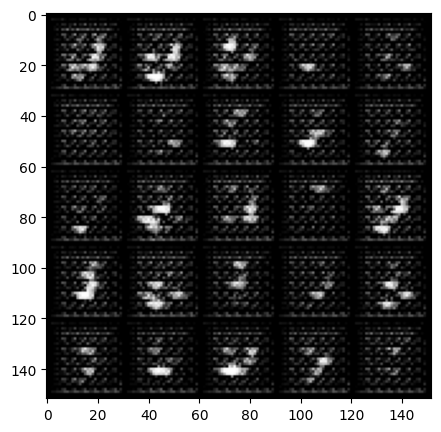

15
15th ['./result/gen_15_0.png']


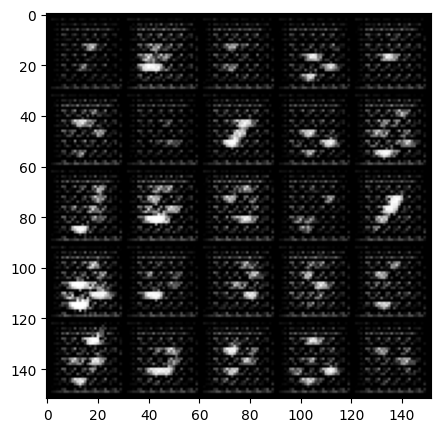

20
20th ['./result/gen_20_0.png']


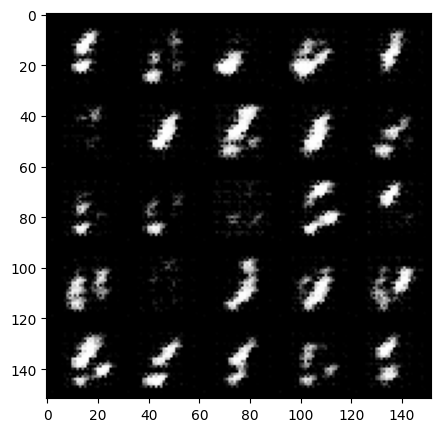

25
25th ['./result/gen_25_0.png']


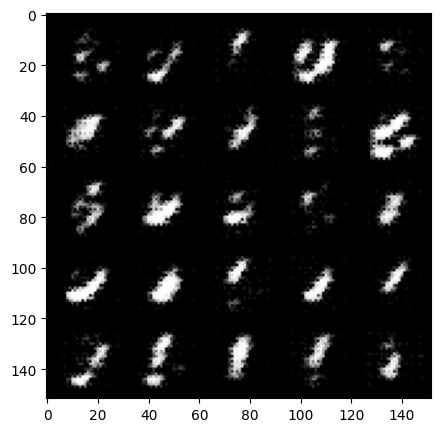

30
30th ['./result/gen_30_0.png']


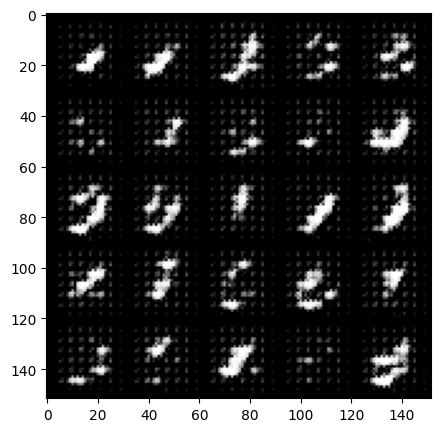

35
35th ['./result/gen_35_0.png']


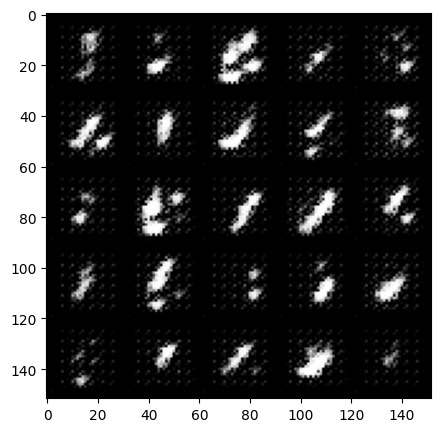

40
40th ['./result/gen_40_0.png']


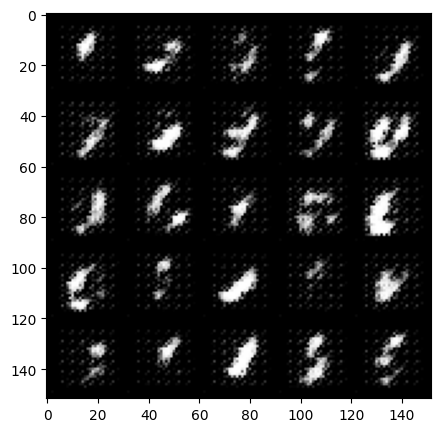

45
45th ['./result/gen_45_0.png']


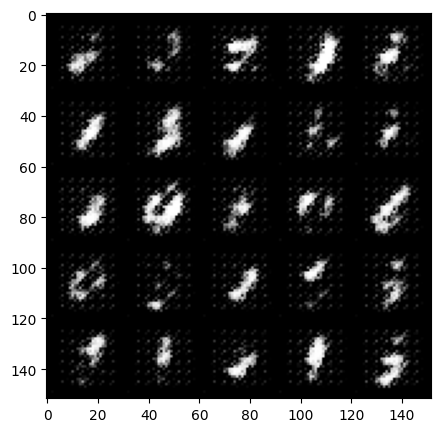

50
50th ['./result/gen_50_0.png']


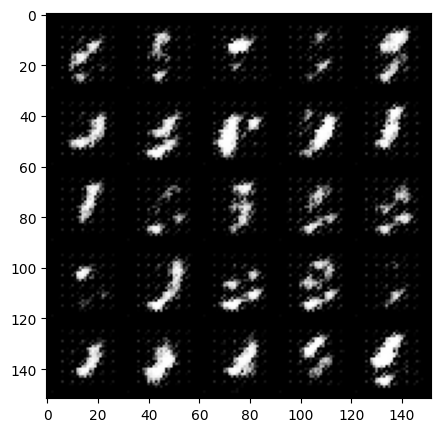

55
55th ['./result/gen_55_0.png']


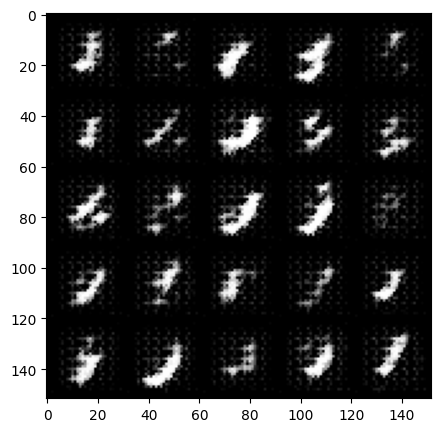

60
60th ['./result/gen_60_0.png']


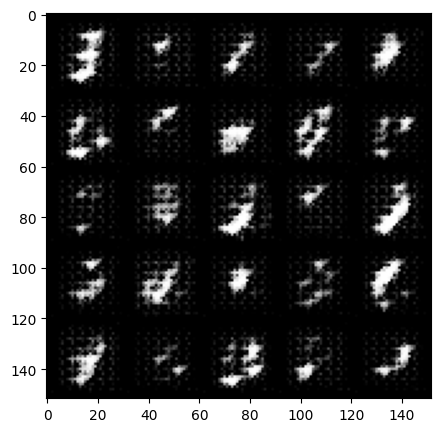

65
65th ['./result/gen_65_0.png']


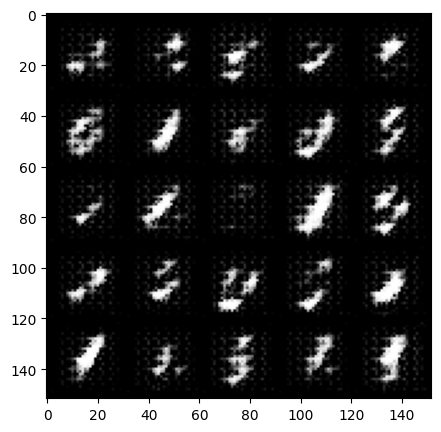

70
70th ['./result/gen_70_0.png']


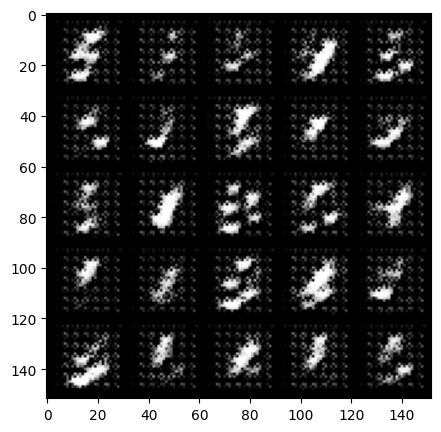

75
75th ['./result/gen_75_0.png']


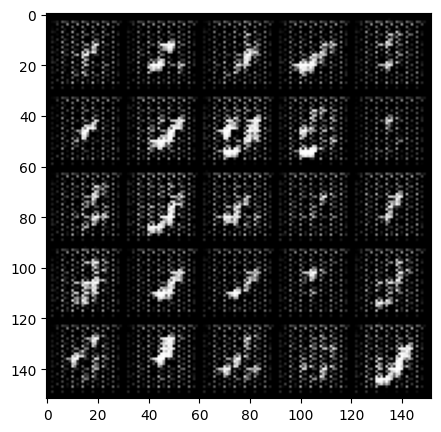

80
80th ['./result/gen_80_0.png']


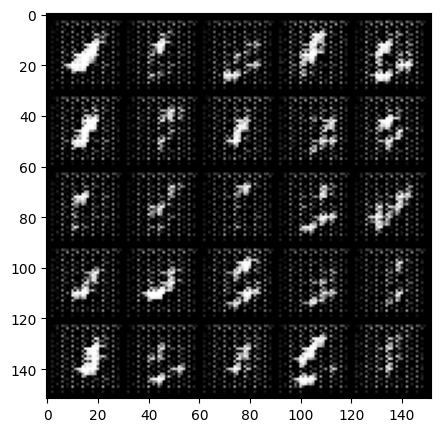

85
85th ['./result/gen_85_0.png']


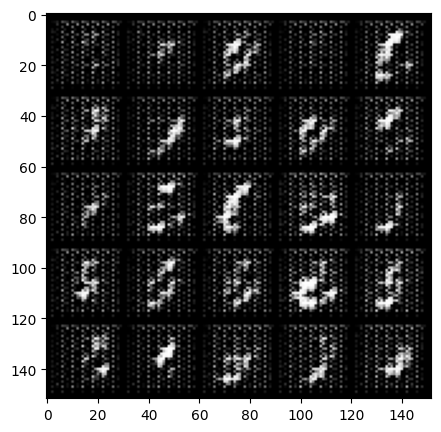

90
90th ['./result/gen_90_0.png']


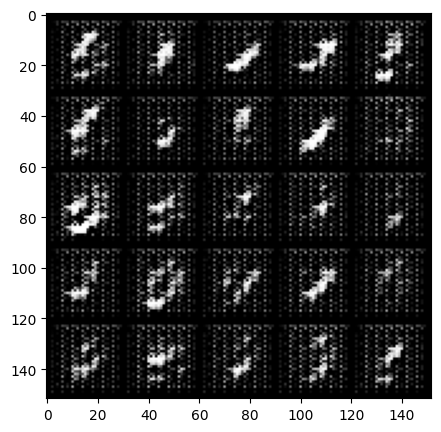

95
95th ['./result/gen_95_0.png']


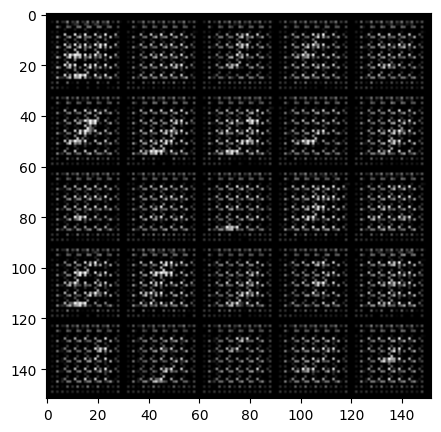

In [11]:
from glob import glob

for i in range(0, epoch, 5):
  print(i)
  file_list = glob("./result/gen_{}_*.png".format(i))
  print("{}th {}".format(i,file_list))
  img_per_epoch = len(file_list)
  plt.figure(figsize=(25, 5))
  for idx,j in enumerate(file_list):
    img = plt.imread(j)
    plt.subplot(1, img_per_epoch, idx+1)
    plt.imshow(img)
  plt.show()